# Anime or Not Classifier

Note: this anime or not classifier frames the task as a multi-label problem, in which the model is allowed to provide a confidence for each class. In other words, the predictions do not sum to 1, and so there is the possibility for learning whether some images have zero matches or more than one match

In [1]:
#Uncomment in google drive
#!pip install -Uqq fastbook

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import fastbook
fastbook.setup_book()

In [6]:
from fastbook import *
from fastai.vision.all import *

In [29]:
import pandas as pd
import numpy as np

### Create Dataset

In [123]:
# root to images
root_path = Path("../data/train_anime_or_not/")

#### Create a dataframe that contains the columns: fname, label

In [110]:
def get_dataframe(root_path):

    imgs = get_image_files(root_path) # get all images
    items = [[img, img.parent.name] for img in imgs] # first item is path to image, second item is the label
    return pd.DataFrame(items, columns=['fname','label'])

In [111]:
df = get_dataframe(root_path)

#### Create a DataBlock Object

In [170]:
def get_x(r): return r['fname'] # return the path to image
def get_y(r): return [r['label']] # return a list since we are building a multilabel model

db = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock), # use multicategoryblock for multilabel
    get_x=get_x, # get inputs 
    get_y=get_y, # get labels
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # 20% for validation with a seed of 42
    item_tfms=Resize(500), # images were previously resized to 400x400, so resize again to a larger size (presizing)
    batch_tfms=aug_transforms(size=224, min_scale=0.75) # minimum scale of crop, defaults to RandomResizedCrop
)

dsets = db.datasets(df) # to quickly check the datasets

In [135]:
# check a sample image and label
dsets.train[150]

(PILImage mode=RGB size=400x265, TensorMultiCategory([0., 1.]))

In [136]:
dsets.vocab

['anime', 'cartoon']

In [137]:
# check the what are the largest/smallest sized images
img_sizes = pd.DataFrame([[dsets[idx][0].size[0], dsets[idx][0].size[1]] for idx in range(len(dsets))])

In [138]:
# the largest size is 400x400 since images were resized beforehand
img_sizes.max()

0    400
1    400
dtype: int64

In [171]:
# create dataloaders object
dls = db.dataloaders(df, bs=16)

In [172]:
len(dls.train), len(dls.valid)

(10, 3)

In [185]:
len(dsets.valid)

39

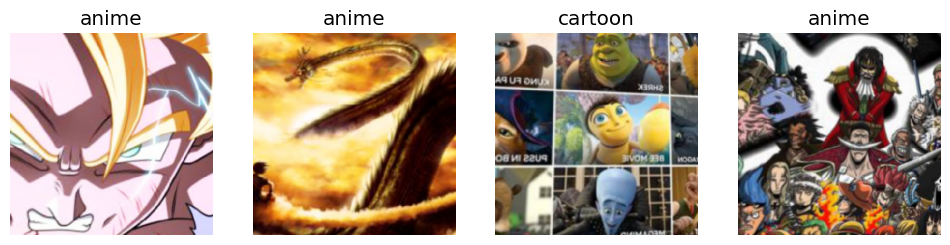

In [174]:
# Inspect a batch
dls.train.show_batch(max_n=4, nrows=1, unique=False)

## Train Model

In [175]:
# Define learner
# Use a high threshold for accuracy which indicates how confident our model needs to be of its predictions

learn = vision_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.8))

In [176]:
learn.loss_func

FlattenedLoss of BCEWithLogitsLoss()

SuggestedLRs(valley=0.0003981071640737355)

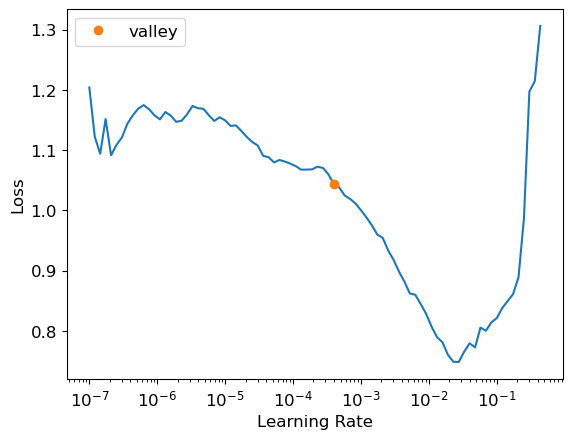

In [177]:
# Use discriminative learning rate (find a suitable lr to start 1cycle learning)
learn.lr_find()

In [181]:
# Train model using lr. Train frozen for 2 epocs, and unfrozen for 6 epochs (Using CPU)
lr=3e-4
learn.fine_tune(6, base_lr=lr, freeze_epochs=2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,1.017539,1.078359,0.448718,00:28
1,0.951452,0.695913,0.551282,00:30


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.805044,0.642127,0.576923,00:43
1,0.810115,0.566107,0.641026,00:41
2,0.712218,0.476677,0.679487,00:40
3,0.645259,0.437038,0.705128,00:41
4,0.611075,0.413959,0.730769,00:42
5,0.563326,0.416746,0.730769,00:41


In [186]:
interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_confusion_matrix()

In [188]:
# interp.plot_top_losses(10, nrows=2, figsize=(19,4))

### Save Model

In [189]:
learn.export('../saved_models/multilabel_model_anime_or_not-cpu.pkl')

### Test Inference on test set

In [233]:
def classify_image(model, path):
    # create an image object
    rows = []
    for img in path:
        im = PILImage.create(img)
        gt = img.parent.name

        pred, idx, probs = model.predict(im)
        row = [img, gt, pred, probs.tolist()]
        rows.append(row)

    return pd.DataFrame(rows, columns=['fname', 'gt', 'pred', 'probs'])

In [234]:
test_path = "../data/test_anime_or_not/"

imgs_test = get_image_files(test_path)
len(imgs_test)

24

In [235]:
results = classify_image(learn, imgs_test)

In [236]:
results

,fname,gt,pred,probs
0,0_SIEGcZ9zkBA5kTiU.png,anime,[anime],"[0.9519157409667969, 0.12153246253728867]"
1,76e74cf374d112f1e36f632bc4f690dc.jpg,anime,"[anime, cartoon]","[0.8738779425621033, 0.6232835650444031]"
2,AAAABU7RFMTdqBhihF-a5_ZXyUUQe0nI9quSa_ImR2iqxIIeej7GO-9SGFXJh79GZMTClniLqRsXCCachadbdOFCjiZODm3yXcBSzsmoKGWCw3BLGX9lLUKiQwMj.jpg,anime,[anime],"[0.7852783799171448, 0.31782665848731995]"
3,ABikyuu-anime-Daichi-Sawamura-paint-by-numbers.jpg,anime,[anime],"[0.7036535143852234, 0.059794843196868896]"
4,dr-stone-richard-eisenbeis-.jpg,anime,[anime],"[0.7884604930877686, 0.1412617713212967]"
5,dr_stone_3.jpg,anime,[anime],"[0.9479600787162781, 0.21706664562225342]"
6,Haikyuu-2-25-4.jpg,anime,[anime],"[0.7860745787620544, 0.060501400381326675]"
7,HD-wallpaper-isshiki-iroha-anime-girl-oregairu-my-youth-romantic-comedy-thumbnail.jpg,anime,[anime],"[0.9706637263298035, 0.09701701253652573]"
8,intro-1636379270.jpg,anime,[],"[0.4258674681186676, 0.0876324400305748]"
9,oregairu.png,anime,[anime],"[0.9537404775619507, 0.13524606823921204]"


### Test Inference (Neither anime nor cartoon)

In [237]:
test_path = "../data/test_anime_or_not/none/"

imgs_test = get_image_files(test_path)

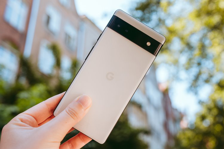

In [238]:
idx=3
im = PILImage.create(imgs_test[idx])
im.to_thumb(224,224)

In [239]:
learn.predict(im)

((#1) ['anime'], tensor([ True, False]), tensor([0.7379, 0.1524]))